# Classify requirements as vague or not using [ktrain](https://github.com/amaiya/ktrain) and tensorflow


## Install dependencies
*ktrain* requires TensorFlow 2.1. See [amaiya/ktrain#151](https://github.com/amaiya/ktrain/issues/151).
Further we install a forked version of eli5lib to gain insights in the model's decision process and some self built helper functions to preprocess MTurk result files.

In [8]:
%load_ext google.colab.data_table
!pip3 install -q tensorflow_gpu==2.1.0 ktrain==0.17.5 imbalanced-learn==0.5.0
!pip3 install -q -U git+https://github.com/HaaLeo/vague-requirements-scripts
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


Check versions and enable logging

In [9]:
import tensorflow as tf
import ktrain
import imblearn

assert tf.__version__ == '2.1.0'
assert ktrain.__version__ == '0.17.5'
assert imblearn.__version__ == '0.5.0'

import logging
import sys

logging.basicConfig(
    format='%(asctime)s [%(name)-20.20s] [%(levelname)-5.5s]  %(message)s',
    stream=sys.stdout,
    level=logging.INFO)

LOGGER = logging.getLogger('colab-notebook')
LOGGER.info('Hello from colab notebook')

2020-07-10 14:49:56,113 [colab-notebook      ] [INFO ]  Hello from colab notebook


## Set Parameters
Set the parameters for this run.
Ktrain ignores `max_features` and `ngram_range` in v0.17.5, see [amaiya/ktrain/issues#190](https://github.com/amaiya/ktrain/issues/190)

In [29]:
#@title Set the parameter and hyperparameter 
#@markdown Set data files and proportion of train, val test set in source code

# Lists are not yet supported as form fields
DATA_FILE_NAMES = [f'corpus-batch-{i}-mturk.csv' for i in range(5)] + ['corpus-batch-5-27-mturk.csv']
TRAIN_VAL_TEST_PROPORTION = [0.8, 0.1, 0.1] # [TestProportion, ValProportion, TestProportion]
CLASS_NAMES = ['not-vague', 'vague'] # 0=not-vague 1=vague

# The following parameter can be edited with the form fields
RANDOM_STATE = 1  #@param {type:"integer"}

RESAMPLING_STRATEGY = 'random_downsampling'#@param ["random_downsampling", "random_upsampling"]

KFOLD_SPLITS = 10 #@param {type:"integer"}
LEARNING_RATE = 1e-5 #@param {type:"number"}
EPOCHS =  1#@param {type:"integer"}
MODEL_NAME = 'distilbert-base-uncased' #@param {type:"string"}
MAX_LEN = 256 #@param {type:"integer"}
BATCH_SIZE = 6 #@param {type:"integer"}
MAX_FEATURES =  35000 #@param {type:"integer"}
NGRAM_RANGE = 1 #@param {type:"integer"}


PREPROCESS_MODE = 'distilbert' #@param {type:"string"}
LOGGER.info('Set parameter successfully')

2020-07-10 15:30:34,690 [colab-notebook      ] [INFO ]  Set parameter successfully


## Load Dataset

### Mount Google Drive
Mount the google drive to access the dataset

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [16]:
from vaguerequirementslib import read_csv_files, build_confusion_matrix, calc_majority_label
import pandas as pd

def read_drive_data(files_list: list, separator: str) -> pd.DataFrame:
    """
    Calculate the majority label for the given source file list

    Args:
        files_list (list): The CSV files to calculate the majority label for
        separator (str): The CSV separator
        drop_ties (bool): If there is a tie in votes (e.g.: One votes for vague one for not vague) then drop this entry from the confusion matrix.

    Returns:
        pd.DataFrame: The dataframe containing the majority label.
    """
    frame = read_csv_files(files_list, separator)
    confusion_matrix = build_confusion_matrix(frame, drop_ties=True)
    return calc_majority_label(confusion_matrix)

# Read all data
df = read_drive_data(
    [f'/content/drive/My Drive/datasets/corpus/labeled/{file_name}' for file_name in DATA_FILE_NAMES],
    ','
  )
df_vague_count = int(df[df.majority_label == 1].majority_label.value_counts())
df_not_vague_count = int(df[df.majority_label == 0].majority_label.value_counts())
LOGGER.info(f'Data frame consists of {df_vague_count} vague data points and {df_not_vague_count} not vague data points.')
df.head()

2020-07-10 14:51:18,500 [vaguerequirementslib] [INFO ]  Build confusion matrix.
2020-07-10 14:51:19,623 [vaguerequirementslib] [INFO ]  Dropped 1228 requirements due to ties.
2020-07-10 14:51:19,628 [vaguerequirementslib] [INFO ]  Built confusion matrix including 1548 of 2776 requirements. 
2020-07-10 14:51:19,632 [vaguerequirementslib] [INFO ]  Overall "vague" votes count = 576. Overall "not vague" votes count = 2520
2020-07-10 14:51:19,751 [vaguerequirementslib] [INFO ]  "vague" majority label count = 288. "not vague" majority label count = 1260.
2020-07-10 14:51:19,763 [colab-notebook      ] [INFO ]  Data frame consists of 288 vague data points and 1260 not vague data points.


,requirement,vague_count,not_vague_count,majority_label
0,A COPV representative of the flight COPV (line...,2,0,1
1,A Charge-Through VCONN -Powered USB Device sha...,0,2,0
2,A Charge-Through VCONN-Powered USB Device shal...,0,2,0
3,A Controller that supports Directed Advertisin...,0,2,0
4,A DC voltage between 0 V and -66 V may be pres...,0,2,0


## Utility Functions

### Resample and preprocess

In [19]:
from typing import Tuple, List

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from ktrain import text as txt

def resample(data_frame: pd.DataFrame, strategy: str = None) -> pd.DataFrame:
    """
    Re sample the given dataframe to contain equally much samples of vague and not-vague requirements.

    Args:
        data_frame (pd.DataFrame): The data frame to upsample.
        strategy (str): The resampling strategy to use either "random_downsampling", "random_upsampling" or None.

    Returns:
        pd.DataFrame: The resampled data frame.
    """
    if strategy:
        if strategy == 'random_downsampling':
            sampler = RandomUnderSampler(sampling_strategy=1., random_state=RANDOM_STATE)
        elif strategy == 'random_upsampling':
            sampler = RandomOverSampler(sampling_strategy=1., random_state=RANDOM_STATE)

        x, y = sampler.fit_resample(data_frame.requirement.to_numpy().reshape(-1, 1), data_frame.majority_label)
        result = pd.DataFrame({'requirement': x.flatten(), 'majority_label': y})

        LOGGER.info(f'Resampled dataset with strategy"{strategy}": vague count="{result.sum()["majority_label"]}", not vague count="{result.shape[0] - result.sum()["majority_label"]}"')
    
    else: 
        LOGGER.warning('Data frame will not be resampled, because no strategy was provided.')
        result = data_frame
    return result

def preprocess_data(data_frame: pd.DataFrame) -> Tuple:
    dummy_df = pd.DataFrame.from_dict({'requirement': ['foo', 'bar'], 'majority_label': [0, 1]})
    LOGGER.info(f'Preprocess the data using preprocess-mode="{PREPROCESS_MODE}", max-features="{MAX_FEATURES}", ngram-range="{NGRAM_RANGE}" and max-len="{MAX_LEN}"')
    data, _, _ = txt.texts_from_df(
        data_frame, 
        text_column='requirement',
        label_columns=['majority_label'], 
        val_df=dummy_df,  
        max_features=MAX_FEATURES,
        maxlen=MAX_LEN,  
        ngram_range=NGRAM_RANGE,
        preprocess_mode=PREPROCESS_MODE,
        random_state=RANDOM_STATE)
    
    return data

### Create result object

Gather results, calulate metrics and write them to the drive.

In [30]:
import os
import json
from os import path

from vaguerequirementslib import TP, TN, FP, FN, calc_all_metrics

def build_fold_result(train_result, val_result, test_result, learning_history) -> dict:
    fold_result = {
        'metrics':{
            'train': {
                'vague': {
                    TP: int(train_result[1][1]),
                    FP: int(train_result[0][1]),
                    TN: int(train_result[0][0]),
                    FN: int(train_result[1][0])
                },
                'not_vague': {
                    TP: int(train_result[0][0]),
                    FP: int(train_result[1][0]),
                    TN: int(train_result[1][1]),
                    FN: int(train_result[0][1])
                }
            },
            'validation': {
                'vague': {
                    TP: int(val_result[1][1]),
                    FP: int(val_result[0][1]),
                    TN: int(val_result[0][0]),
                    FN: int(val_result[1][0])
                },
                'not_vague': {
                    TP: int(val_result[0][0]),
                    FP: int(val_result[1][0]),
                    TN: int(val_result[1][1]),
                    FN: int(val_result[0][1])
                }
            },
            'test': {
                'vague': {
                    TP: int(test_result[1][1]),
                    FP: int(test_result[0][1]),
                    TN: int(test_result[0][0]),
                    FN: int(test_result[1][0])
                },
                'not_vague': {
                    TP: int(test_result[0][0]),
                    FP: int(test_result[1][0]),
                    TN: int(test_result[1][1]),
                    FN: int(test_result[0][1])
                }
            }
        },
        'learning_history': learning_history
    }
    for key in fold_result['metrics']:
        fold_result['metrics'][key]['not_vague'].update(calc_all_metrics(**fold_result['metrics'][key]['not_vague']))
        fold_result['metrics'][key]['vague'].update(calc_all_metrics(**fold_result['metrics'][key]['vague']))

    LOGGER.debug('Successfully built fold result.')

    return fold_result


def build_result_data(fold_results: List, df_vague_count, df_not_vague_count, test_df_vague_count, test_df_not_vague_count) -> dict:
    result_data = {
        'misc': {   
            'random_state': RANDOM_STATE
        },
        'data_set':{
            'summary': {
                'data_files': DATA_FILE_NAMES,
                'vague_data_points': df_vague_count,
                'not_vague_data_points': df_not_vague_count,
            },
            'test': {
                'proportion': TRAIN_VAL_TEST_PROPORTION[2],
                'vague_data_points': test_df_vague_count,
                'not_vague_data_points': test_df_not_vague_count
            }
        },
        'fold_results': fold_results,
        'hyperparameter': {
            'learning_rate': LEARNING_RATE,
            'epochs': EPOCHS,
            'model_name': MODEL_NAME,
            'max_len': MAX_LEN,
            'batch_size': BATCH_SIZE,
            'max_features': MAX_FEATURES,
            'ngram_range': NGRAM_RANGE,
        }
    }

    LOGGER.debug('Successfully built fold result.')
    return result_data

### Save evaluation result

In [36]:
import os
import numpy as np


def save_evaluation_result(result_data: dict) -> None:
    class NumpyJSONEncoder(json.JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            else:
                return super(NumpyJSONEncoder, self).default(obj)

    # Save the evaluation result (test_data results)
    os.makedirs(result_dir, exist_ok=True)
    with open(path.join(result_dir, 'evaluation.json'), mode='w', encoding='utf-8') as json_file:
        json.dump(result_data, json_file, indent=4, cls=NumpyJSONEncoder)
    LOGGER.info(f'Successfully saved evaluation result data to directory="{result_dir}".')

## STEP 1:  Training

We will use [DistilBERT](https://arxiv.org/abs/1910.01108).

### Create a Transformer Model

In [32]:
# Create the transformer
t = txt.Transformer(MODEL_NAME, maxlen=MAX_LEN, class_names=CLASS_NAMES)
t.preprocess_train_called = True # Simulate call to preprocess_train()

# Get the model and learner
model = t.get_classifier()

# Find a suitable learning rate
# learner.lr_find(show_plot=True, start_lr=1e-09, max_epochs=EPOCHS)
# print(learner.lr_estimate())

### K-Fold Cross Validation

2020-07-10 15:31:40,115 [colab-notebook      ] [INFO ]  Test dataset: vague count="29", not vague count="126"
preprocessing train...
language: en
train sequence lengths:
	mean : 21
	95percentile : 43
	99percentile : 59


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:229: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


2020-07-10 15:31:40,599 [colab-notebook      ] [INFO ]  ######################
### Process fold 1
######################
2020-07-10 15:31:40,611 [colab-notebook      ] [INFO ]  Training dataset: vague count="233", not vague count="1020"
2020-07-10 15:31:40,619 [colab-notebook      ] [INFO ]  Validation dataset: vague count="26", not vague count="114"
2020-07-10 15:31:40,620 [colab-notebook      ] [INFO ]  Resample training data set.
2020-07-10 15:31:40,634 [colab-notebook      ] [INFO ]  Resampled dataset with strategy"random_downsampling": vague count="233", not vague count="233"
2020-07-10 15:31:40,636 [colab-notebook      ] [INFO ]  Preprocess training and validation data for the model=distilbert-base-uncased
preprocessing train...
language: en
train sequence lengths:
	mean : 23
	95percentile : 44
	99percentile : 61


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:229: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


preprocessing train...
language: en
train sequence lengths:
	mean : 21
	95percentile : 37
	99percentile : 43


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


2020-07-10 15:31:41,856 [colab-notebook      ] [INFO ]  Fit the model for one cycle


begin training using onecycle policy with max lr of 1e-05...
Train for 78 steps, validate for 5 steps
78/78 [==============================] - 40s 507ms/step - loss: 0.6878 - accuracy: 0.5408 - val_loss: 0.6627 - val_accuracy: 0.6857


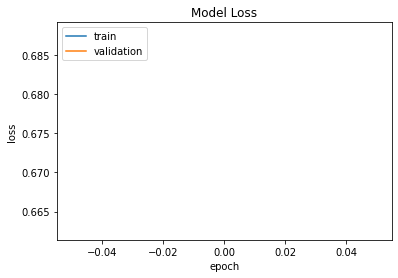

              precision    recall  f1-score   support

   not-vague       0.88      0.73      0.80       126
       vague       0.32      0.55      0.41        29

    accuracy                           0.70       155
   macro avg       0.60      0.64      0.60       155
weighted avg       0.77      0.70      0.72       155

2020-07-10 15:32:43,155 [colab-notebook      ] [INFO ]  ######################
### Process fold 2
######################
2020-07-10 15:32:43,169 [colab-notebook      ] [INFO ]  Training dataset: vague count="233", not vague count="1020"
2020-07-10 15:32:43,180 [colab-notebook      ] [INFO ]  Validation dataset: vague count="26", not vague count="114"
2020-07-10 15:32:43,182 [colab-notebook      ] [INFO ]  Resample training data set.
2020-07-10 15:32:43,200 [colab-notebook      ] [INFO ]  Resampled dataset with strategy"random_downsampling": vague count="233", not vague count="233"
2020-07-10 15:32:43,202 [colab-notebook      ] [INFO ]  Preprocess training and valid

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:229: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


preprocessing train...
language: en
train sequence lengths:
	mean : 24
	95percentile : 48
	99percentile : 68


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


2020-07-10 15:32:44,488 [colab-notebook      ] [INFO ]  Fit the model for one cycle


begin training using onecycle policy with max lr of 1e-05...
Train for 78 steps, validate for 5 steps
78/78 [==============================] - 29s 368ms/step - loss: 0.6741 - accuracy: 0.6309 - val_loss: 0.6702 - val_accuracy: 0.6286


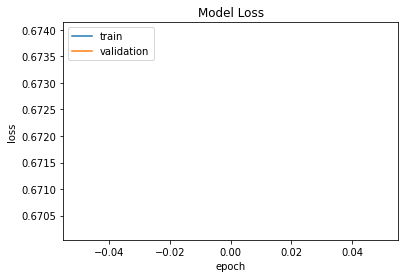

              precision    recall  f1-score   support

   not-vague       0.89      0.63      0.74       126
       vague       0.29      0.66      0.40        29

    accuracy                           0.64       155
   macro avg       0.59      0.65      0.57       155
weighted avg       0.78      0.64      0.68       155

2020-07-10 15:33:33,745 [colab-notebook      ] [INFO ]  ######################
### Process fold 3
######################
2020-07-10 15:33:33,756 [colab-notebook      ] [INFO ]  Training dataset: vague count="233", not vague count="1020"
2020-07-10 15:33:33,763 [colab-notebook      ] [INFO ]  Validation dataset: vague count="26", not vague count="114"
2020-07-10 15:33:33,765 [colab-notebook      ] [INFO ]  Resample training data set.
2020-07-10 15:33:33,784 [colab-notebook      ] [INFO ]  Resampled dataset with strategy"random_downsampling": vague count="233", not vague count="233"
2020-07-10 15:33:33,785 [colab-notebook      ] [INFO ]  Preprocess training and valid

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:229: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


preprocessing train...
language: en
train sequence lengths:
	mean : 21
	95percentile : 40
	99percentile : 66


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


2020-07-10 15:33:35,118 [colab-notebook      ] [INFO ]  Fit the model for one cycle


begin training using onecycle policy with max lr of 1e-05...
Train for 78 steps, validate for 5 steps
78/78 [==============================] - 29s 366ms/step - loss: 0.6326 - accuracy: 0.6652 - val_loss: 0.6164 - val_accuracy: 0.6714


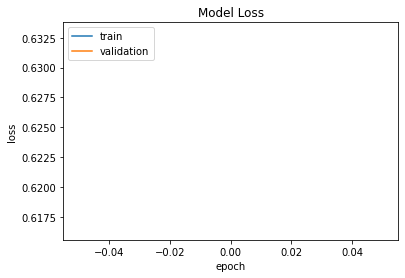

              precision    recall  f1-score   support

   not-vague       0.89      0.74      0.81       126
       vague       0.34      0.59      0.43        29

    accuracy                           0.71       155
   macro avg       0.61      0.66      0.62       155
weighted avg       0.78      0.71      0.74       155

2020-07-10 15:34:23,795 [colab-notebook      ] [INFO ]  ######################
### Process fold 4
######################
2020-07-10 15:34:23,811 [colab-notebook      ] [INFO ]  Training dataset: vague count="233", not vague count="1020"
2020-07-10 15:34:23,821 [colab-notebook      ] [INFO ]  Validation dataset: vague count="26", not vague count="114"
2020-07-10 15:34:23,822 [colab-notebook      ] [INFO ]  Resample training data set.
2020-07-10 15:34:23,837 [colab-notebook      ] [INFO ]  Resampled dataset with strategy"random_downsampling": vague count="233", not vague count="233"
2020-07-10 15:34:23,838 [colab-notebook      ] [INFO ]  Preprocess training and valid

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:229: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


preprocessing train...
language: en
train sequence lengths:
	mean : 20
	95percentile : 40
	99percentile : 46


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


2020-07-10 15:34:25,087 [colab-notebook      ] [INFO ]  Fit the model for one cycle


begin training using onecycle policy with max lr of 1e-05...
Train for 78 steps, validate for 5 steps
78/78 [==============================] - 29s 368ms/step - loss: 0.5907 - accuracy: 0.7017 - val_loss: 0.5211 - val_accuracy: 0.7714


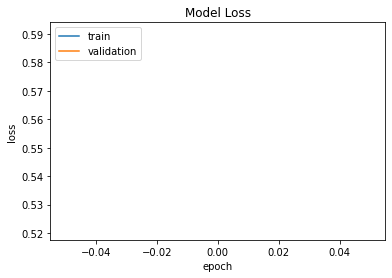

              precision    recall  f1-score   support

   not-vague       0.92      0.69      0.79       126
       vague       0.35      0.72      0.47        29

    accuracy                           0.70       155
   macro avg       0.63      0.71      0.63       155
weighted avg       0.81      0.70      0.73       155

2020-07-10 15:35:13,934 [colab-notebook      ] [INFO ]  ######################
### Process fold 5
######################
2020-07-10 15:35:13,946 [colab-notebook      ] [INFO ]  Training dataset: vague count="233", not vague count="1021"
2020-07-10 15:35:13,953 [colab-notebook      ] [INFO ]  Validation dataset: vague count="26", not vague count="113"
2020-07-10 15:35:13,954 [colab-notebook      ] [INFO ]  Resample training data set.
2020-07-10 15:35:13,972 [colab-notebook      ] [INFO ]  Resampled dataset with strategy"random_downsampling": vague count="233", not vague count="233"
2020-07-10 15:35:13,973 [colab-notebook      ] [INFO ]  Preprocess training and valid

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:229: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


preprocessing train...
language: en
train sequence lengths:
	mean : 21
	95percentile : 37
	99percentile : 51


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


2020-07-10 15:35:15,213 [colab-notebook      ] [INFO ]  Fit the model for one cycle


begin training using onecycle policy with max lr of 1e-05...
Train for 78 steps, validate for 5 steps
78/78 [==============================] - 29s 367ms/step - loss: 0.5501 - accuracy: 0.7489 - val_loss: 0.4251 - val_accuracy: 0.7986


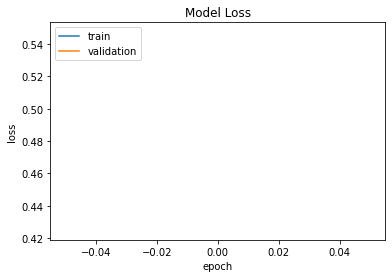

              precision    recall  f1-score   support

   not-vague       0.83      0.92      0.88       126
       vague       0.38      0.21      0.27        29

    accuracy                           0.79       155
   macro avg       0.60      0.56      0.57       155
weighted avg       0.75      0.79      0.76       155

2020-07-10 15:36:03,962 [colab-notebook      ] [INFO ]  ######################
### Process fold 6
######################
2020-07-10 15:36:03,973 [colab-notebook      ] [INFO ]  Training dataset: vague count="233", not vague count="1021"
2020-07-10 15:36:03,978 [colab-notebook      ] [INFO ]  Validation dataset: vague count="26", not vague count="113"
2020-07-10 15:36:03,979 [colab-notebook      ] [INFO ]  Resample training data set.
2020-07-10 15:36:03,997 [colab-notebook      ] [INFO ]  Resampled dataset with strategy"random_downsampling": vague count="233", not vague count="233"
2020-07-10 15:36:03,999 [colab-notebook      ] [INFO ]  Preprocess training and valid

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:229: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


preprocessing train...
language: en
train sequence lengths:
	mean : 20
	95percentile : 38
	99percentile : 48


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


2020-07-10 15:36:05,317 [colab-notebook      ] [INFO ]  Fit the model for one cycle


begin training using onecycle policy with max lr of 1e-05...
Train for 78 steps, validate for 5 steps
78/78 [==============================] - 29s 368ms/step - loss: 0.5058 - accuracy: 0.7790 - val_loss: 0.4813 - val_accuracy: 0.7698


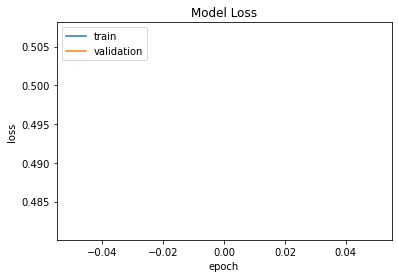

              precision    recall  f1-score   support

   not-vague       0.90      0.79      0.84       126
       vague       0.40      0.62      0.49        29

    accuracy                           0.75       155
   macro avg       0.65      0.70      0.66       155
weighted avg       0.81      0.75      0.77       155

2020-07-10 15:36:54,048 [colab-notebook      ] [INFO ]  ######################
### Process fold 7
######################
2020-07-10 15:36:54,060 [colab-notebook      ] [INFO ]  Training dataset: vague count="233", not vague count="1021"
2020-07-10 15:36:54,067 [colab-notebook      ] [INFO ]  Validation dataset: vague count="26", not vague count="113"
2020-07-10 15:36:54,071 [colab-notebook      ] [INFO ]  Resample training data set.
2020-07-10 15:36:54,088 [colab-notebook      ] [INFO ]  Resampled dataset with strategy"random_downsampling": vague count="233", not vague count="233"
2020-07-10 15:36:54,091 [colab-notebook      ] [INFO ]  Preprocess training and valid

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:229: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


preprocessing train...
language: en
train sequence lengths:
	mean : 21
	95percentile : 37
	99percentile : 45


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


2020-07-10 15:36:55,386 [colab-notebook      ] [INFO ]  Fit the model for one cycle


begin training using onecycle policy with max lr of 1e-05...
Train for 78 steps, validate for 5 steps
78/78 [==============================] - 29s 368ms/step - loss: 0.4634 - accuracy: 0.7940 - val_loss: 0.3650 - val_accuracy: 0.8489


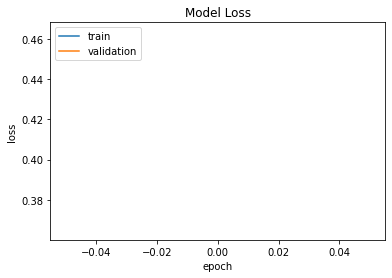

              precision    recall  f1-score   support

   not-vague       0.86      0.86      0.86       126
       vague       0.40      0.41      0.41        29

    accuracy                           0.77       155
   macro avg       0.63      0.64      0.63       155
weighted avg       0.78      0.77      0.78       155

2020-07-10 15:37:44,044 [colab-notebook      ] [INFO ]  ######################
### Process fold 8
######################
2020-07-10 15:37:44,054 [colab-notebook      ] [INFO ]  Training dataset: vague count="233", not vague count="1021"
2020-07-10 15:37:44,060 [colab-notebook      ] [INFO ]  Validation dataset: vague count="26", not vague count="113"
2020-07-10 15:37:44,061 [colab-notebook      ] [INFO ]  Resample training data set.
2020-07-10 15:37:44,079 [colab-notebook      ] [INFO ]  Resampled dataset with strategy"random_downsampling": vague count="233", not vague count="233"
2020-07-10 15:37:44,081 [colab-notebook      ] [INFO ]  Preprocess training and valid

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:229: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


preprocessing train...
language: en
train sequence lengths:
	mean : 19
	95percentile : 34
	99percentile : 46


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


2020-07-10 15:37:45,403 [colab-notebook      ] [INFO ]  Fit the model for one cycle


begin training using onecycle policy with max lr of 1e-05...
Train for 78 steps, validate for 5 steps
78/78 [==============================] - 29s 368ms/step - loss: 0.4350 - accuracy: 0.8155 - val_loss: 0.3075 - val_accuracy: 0.8561


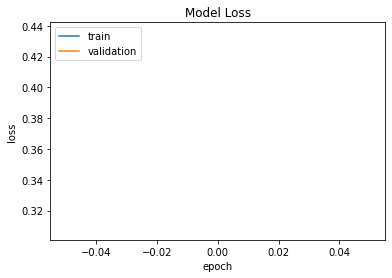

              precision    recall  f1-score   support

   not-vague       0.84      0.85      0.85       126
       vague       0.32      0.31      0.32        29

    accuracy                           0.75       155
   macro avg       0.58      0.58      0.58       155
weighted avg       0.75      0.75      0.75       155

2020-07-10 15:38:34,123 [colab-notebook      ] [INFO ]  ######################
### Process fold 9
######################
2020-07-10 15:38:34,133 [colab-notebook      ] [INFO ]  Training dataset: vague count="233", not vague count="1021"
2020-07-10 15:38:34,141 [colab-notebook      ] [INFO ]  Validation dataset: vague count="26", not vague count="113"
2020-07-10 15:38:34,142 [colab-notebook      ] [INFO ]  Resample training data set.
2020-07-10 15:38:34,158 [colab-notebook      ] [INFO ]  Resampled dataset with strategy"random_downsampling": vague count="233", not vague count="233"
2020-07-10 15:38:34,159 [colab-notebook      ] [INFO ]  Preprocess training and valid

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:229: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


preprocessing train...
language: en
train sequence lengths:
	mean : 21
	95percentile : 38
	99percentile : 63


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


2020-07-10 15:38:35,531 [colab-notebook      ] [INFO ]  Fit the model for one cycle


begin training using onecycle policy with max lr of 1e-05...
Train for 78 steps, validate for 5 steps
78/78 [==============================] - 29s 367ms/step - loss: 0.3524 - accuracy: 0.8712 - val_loss: 0.3276 - val_accuracy: 0.8561


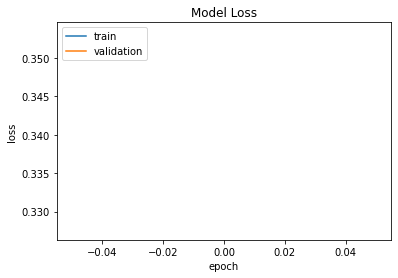

              precision    recall  f1-score   support

   not-vague       0.84      0.82      0.83       126
       vague       0.28      0.31      0.30        29

    accuracy                           0.72       155
   macro avg       0.56      0.56      0.56       155
weighted avg       0.73      0.72      0.73       155

2020-07-10 15:39:24,045 [colab-notebook      ] [INFO ]  ######################
### Process fold 10
######################
2020-07-10 15:39:24,056 [colab-notebook      ] [INFO ]  Training dataset: vague count="234", not vague count="1021"
2020-07-10 15:39:24,067 [colab-notebook      ] [INFO ]  Validation dataset: vague count="25", not vague count="113"
2020-07-10 15:39:24,067 [colab-notebook      ] [INFO ]  Resample training data set.
2020-07-10 15:39:24,085 [colab-notebook      ] [INFO ]  Resampled dataset with strategy"random_downsampling": vague count="234", not vague count="234"
2020-07-10 15:39:24,086 [colab-notebook      ] [INFO ]  Preprocess training and vali

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:229: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


preprocessing train...
language: en
train sequence lengths:
	mean : 21
	95percentile : 40
	99percentile : 53


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


2020-07-10 15:39:25,363 [colab-notebook      ] [INFO ]  Fit the model for one cycle


begin training using onecycle policy with max lr of 1e-05...
Train for 78 steps, validate for 5 steps
78/78 [==============================] - 29s 368ms/step - loss: 0.3471 - accuracy: 0.8504 - val_loss: 0.3108 - val_accuracy: 0.8623


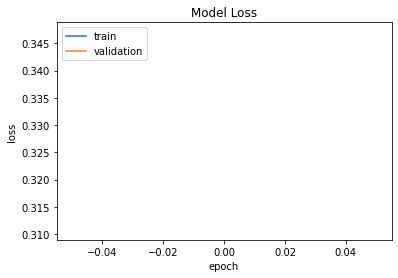

              precision    recall  f1-score   support

   not-vague       0.85      0.79      0.82       126
       vague       0.32      0.41      0.36        29

    accuracy                           0.72       155
   macro avg       0.59      0.60      0.59       155
weighted avg       0.75      0.72      0.74       155

2020-07-10 15:40:14,020 [colab-notebook      ] [INFO ]  Successfully trained model.


NameError: ignored

In [33]:
from datetime import datetime
from pytz import timezone
from sklearn.model_selection import StratifiedKFold

# For every triggered fitting run create a new directory where the results will be saved
now = datetime.now(timezone('Europe/Berlin'))
result_dir = f'/content/drive/My Drive/runs/{now.strftime("%Y-%m-%d/%H-%M-%S")}'
fold_results = []

# Split data for k folds and test data
kfold_df, test_df = train_test_split(df, test_size=TRAIN_VAL_TEST_PROPORTION[2], random_state=RANDOM_STATE, stratify=df['majority_label'])

test_df_vague_count = int(test_df[test_df.majority_label == 1].majority_label.value_counts())
test_df_not_vague_count = int(test_df[test_df.majority_label == 0].majority_label.value_counts())
LOGGER.info(f'Test dataset: vague count="{test_df_vague_count}", not vague count="{test_df_not_vague_count}"')

test_data = preprocess_data(test_df)
fold_counter = 1
# Cerate k folds
kfold = StratifiedKFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=RANDOM_STATE)
for train_idx, val_idx in kfold.split(kfold_df.requirement, kfold_df.majority_label):
    LOGGER.info(f'\n######################\n### Process fold {fold_counter}\n######################')

    # Get training data and validation data for this fold
    train_df = kfold_df.iloc[train_idx]
    val_df = kfold_df.iloc[val_idx]
    LOGGER.info(f'Training dataset: vague count="{int(train_df[train_df.majority_label == 1].majority_label.value_counts())}", not vague count="{int(train_df[train_df.majority_label == 0].majority_label.value_counts())}".')
    LOGGER.info(f'Validation dataset: vague count="{int(val_df[val_df.majority_label == 1].majority_label.value_counts())}", not vague count="{int(val_df[val_df.majority_label == 0].majority_label.value_counts())}".')
    
    # Resample train df 
    LOGGER.info('Resample training data set.')
    train_df = resample(train_df, RESAMPLING_STRATEGY)

    LOGGER.info(f'Preprocess training and validation data for the model="{MODEL_NAME}".')
    train_data = preprocess_data(train_df)
    val_data = preprocess_data(val_df)

    # Get the learner for the new fold
    LOGGER.info('Fit the model for one cycle.')
    learner = ktrain.get_learner(model, train_data=train_data, val_data=val_data, batch_size=BATCH_SIZE)

    # Fit the model
    learning_history = learner.fit_onecycle(LEARNING_RATE, EPOCHS).history
    learner.plot('loss')

    # Evaluate the model
    train_result = learner.validate(class_names=CLASS_NAMES, val_data=train_data, print_report=False)
    val_result = learner.validate(class_names=CLASS_NAMES, val_data=val_data, print_report=False)
    test_result = learner.validate(class_names=CLASS_NAMES, val_data=test_data)

    # build fold result
    fold_result = build_fold_result(train_result, val_result, test_result, learning_history)
    fold_results.append(fold_result)

    fold_counter += 1

LOGGER.info('Successfully trained model.')

# Save the evaluation results
evaluation_result = build_result_data(fold_results, df_vague_count, df_not_vague_count, test_df_vague_count, test_df_not_vague_count)
save_evaluation_result(evaluation_result)

predictor = ktrain.get_predictor(learner.model, preproc=t)

## STEP 2: Evaluate the model
Evaluate the model using the `test_data`.

2020-07-10 15:41:33,082 [colab-notebook      ] [INFO ]  Successfully saved evaluation result data to directory="/content/drive/My Drive/runs/2020-07-10/17-31-40".
              precision    recall  f1-score   support

   not-vague       0.85      0.79      0.82       126
       vague       0.32      0.41      0.36        29

    accuracy                           0.72       155
   macro avg       0.59      0.60      0.59       155
weighted avg       0.75      0.72      0.74       155

[[100  26]
 [ 17  12]]


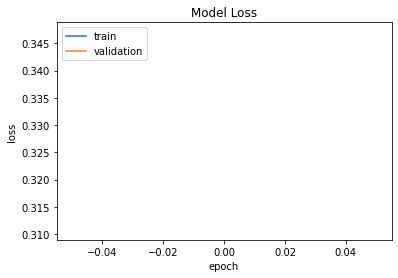

2020-07-10 15:41:40,088 [colab-notebook      ] [INFO ]  Successfully validated test set.


In [37]:
test_result = learner.validate(class_names=CLASS_NAMES, val_data=test_data)
print(test_result)
learner.plot('loss')
LOGGER.info('Successfully validated test set.')

## STEP 3.1 Save the predictor
Check out the [FAQ](https://github.com/amaiya/ktrain/blob/master/FAQ.md#method-1-using-predictor-api-works-for-any-model) for how to load a model from a predictor.

In [ ]:
from os import path

# Save the corresponding model (predictor)
predictor.save(path.join(result_dir, 'predictor'))

2020-07-07 20:06:38,977 [colab-notebook      ] [INFO ]  Successfully saved result data to directory="/content/drive/My Drive/runs/2020-07-07/21-56-22".


## STEP 4 Inspect the Model and its Losses

Let's examine the validation example about which we were the most wrong.

In [ ]:
learner.view_top_losses(n=4, preproc=t, val_data=test_data)
top_losses = learner.top_losses(n=4, preproc=t, val_data=test_data)

----------
id:16 | loss:1.26 | true:not-vague | pred:vague)

----------
id:22 | loss:1.2 | true:not-vague | pred:vague)

----------
id:12 | loss:1.18 | true:not-vague | pred:vague)

----------
id:8 | loss:0.99 | true:vague | pred:not-vague)



In [ ]:
top_loss_req = test_df.iloc[16]['requirement'] # Requirement that produces top loss

print(predictor.predict(top_loss_req))

# predicted probability scores for each category
print(predictor.predict_proba(top_loss_req))
print(top_loss_req)

2020-07-07 07:56:25,775 [MainThread          ] [DEBUG]  Starting new HTTPS connection (1): s3.amazonaws.com:443
2020-07-07 07:56:26,194 [MainThread          ] [DEBUG]  https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-base-uncased-vocab.txt HTTP/1.1" 200 0


vague


[0.28304783 0.71695215]
The developer shall establish, control, and maintain a software test environment to perform integration and qualification testing of software.


Let's invoke the `explain` method to see which words contribute most to the classification.

In [ ]:
from IPython.core.display import display

for id, _, _, _ in top_losses:
    top_loss_req = test_df.iloc[id]['requirement'] # Requirement that produces top loss
    display(predictor.explain(top_loss_req, n_samples=1_000))

The words in the darkest shade of green contribute most to the classification and agree with what you would expect for this example.